<a href="https://colab.research.google.com/github/inabubblewithyou/vectorizer/blob/main/Vectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Phase 5: Intelligent Grouping + Semantic SVG Annotation

# ✅ Install dependencies
!pip install git+https://github.com/facebookresearch/segment-anything.git > /dev/null
!pip install opencv-python-headless scikit-learn > /dev/null


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e78nol5o


In [10]:
# --- imports ---

import numpy as np
import cv2
from PIL import Image
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import os
from sklearn.cluster import KMeans
from google.colab import files
from IPython.display import display, SVG
import urllib.request
import uuid

In [11]:
# 📥 Download SAM checkpoint if not already present
checkpoint_name = "sam_vit_b_01ec64.pth"
checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"

if not os.path.exists(checkpoint_name):
    print("📥 Downloading SAM checkpoint...")
    urllib.request.urlretrieve(checkpoint_url, checkpoint_name)
    print("✅ Checkpoint downloaded successfully.")
else:
    print("✅ Checkpoint already exists. Skipping download.")


✅ Checkpoint already exists. Skipping download.


📁 Found existing image files:
  1: ChatGPT Image Jun 8, 2025, 10_06_48 PM.png

Do you want to use one of these or upload a new image?
Enter the number of the image to use it, or 0 to upload a new one.
Your choice (0 to upload): 1


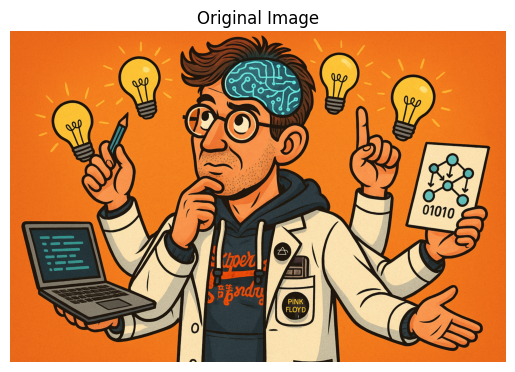

🔄 Generating fine-grained masks with SAM...
✅ 249 masks generated
🔁 Merging overlapping masks into full object segments
✅ 202 merged masks ready
🧠 Grouping masks into logical objects
🔧 Refining masks before SVG export
🧬 Exporting grouped masks to SVG


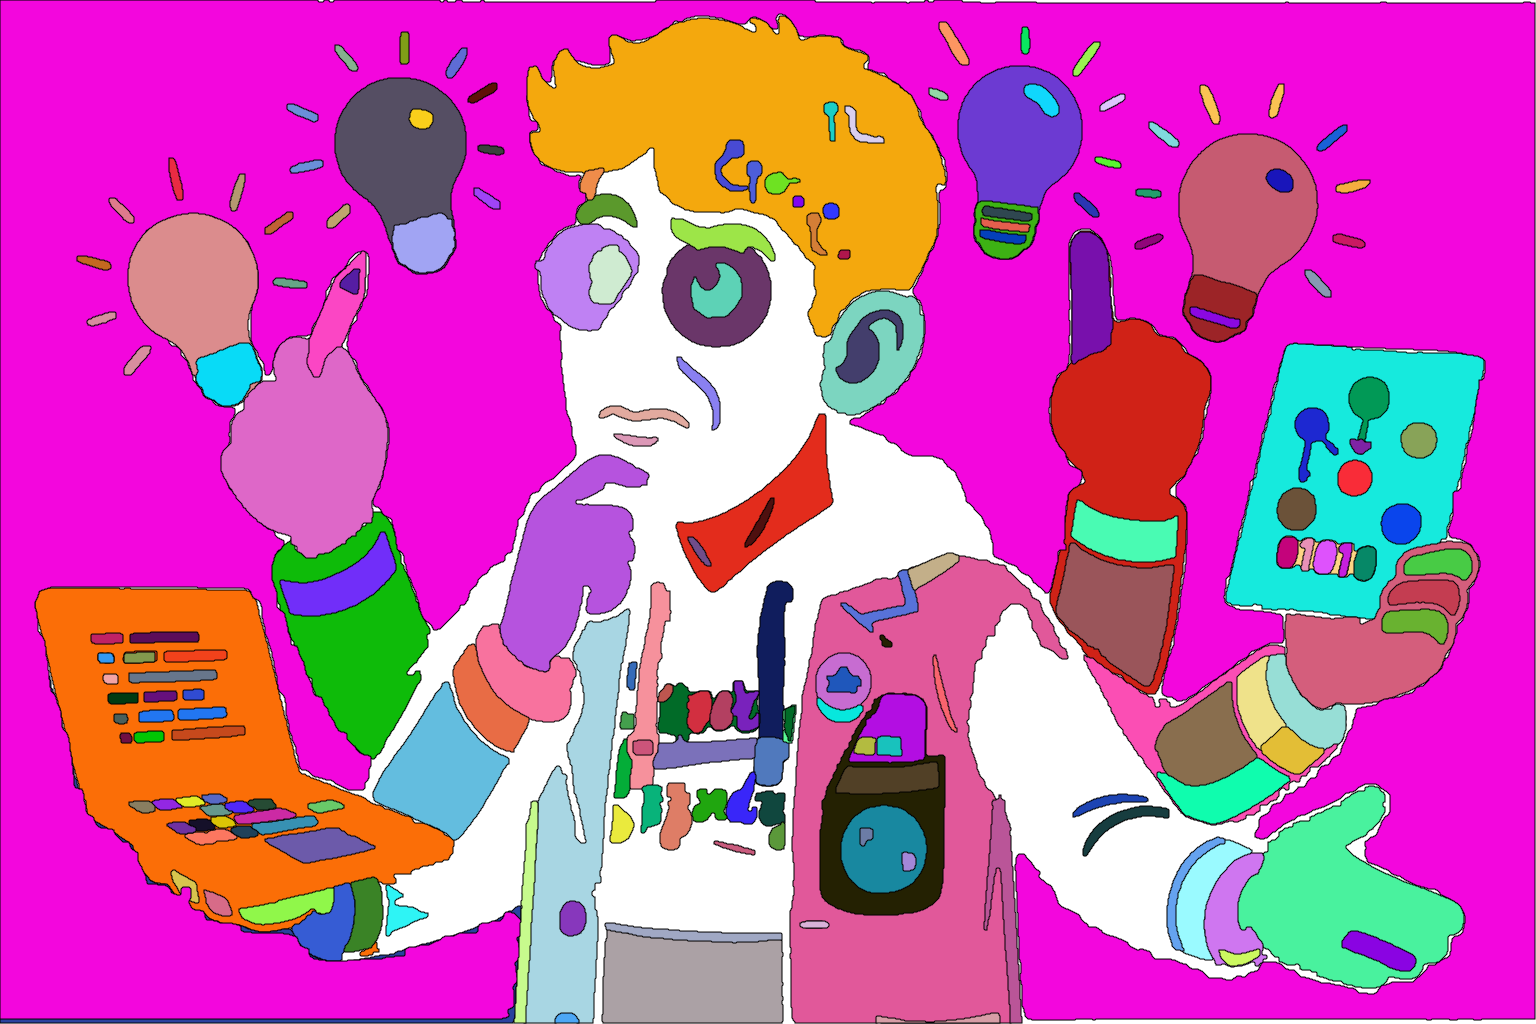

✅ SVG with refined grouped segments ready for animation, tooltips, or interactivity


In [12]:
# 🔍 Look for existing PNG or JPG files
available_images = [f for f in os.listdir('.') if f.lower().endswith(('png', 'jpg', 'jpeg'))]

if available_images:
    print("📁 Found existing image files:")
    for i, fname in enumerate(available_images):
        print(f"  {i+1}: {fname}")
    print("\nDo you want to use one of these or upload a new image?")
    print("Enter the number of the image to use it, or 0 to upload a new one.")
    selection = input("Your choice (0 to upload): ")
    try:
        selection = int(selection)
    except ValueError:
        selection = 0
    if selection == 0:
        print("📤 Upload your image file (PNG or JPG)")
        uploaded = files.upload()
        image_file = next((f for f in uploaded if f.lower().endswith(('png', 'jpg', 'jpeg'))), None)
        if image_file is None:
            raise RuntimeError("❌ No image file uploaded.")
    else:
        image_file = available_images[selection - 1]
else:
    print("📤 No images found. Please upload a PNG or JPG image.")
    uploaded = files.upload()
    image_file = next((f for f in uploaded if f.lower().endswith(('png', 'jpg', 'jpeg'))), None)
    if image_file is None:
        raise RuntimeError("❌ No image file uploaded.")

image = Image.open(image_file).convert("RGB")
image_np = np.array(image)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')
plt.show()

model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry[model_type](checkpoint=checkpoint_name)
sam.to(device)

print("🔄 Generating fine-grained masks with SAM...")
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=128,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.90,
    crop_n_layers=1,
    min_mask_region_area=50
)
masks = mask_generator.generate(image_np)
print(f"✅ {len(masks)} masks generated")

masks = sorted(masks, key=lambda x: x['area'], reverse=True)

# --- Postprocess and Merge Overlapping Masks ---
def get_centroid(mask):
    y, x = np.where(mask)
    return np.array([np.mean(x), np.mean(y)]) if len(x) > 0 else np.array([0, 0])

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union if union > 0 else 0

print("🔁 Merging overlapping masks into full object segments")
merged = []
used = set()
for i, mask_i in enumerate(masks):
    if i in used:
        continue
    merged_mask = mask_i['segmentation'].copy()
    for j in range(i+1, len(masks)):
        if j in used:
            continue
        if compute_iou(merged_mask, masks[j]['segmentation']) > 0.3:
            merged_mask = np.logical_or(merged_mask, masks[j]['segmentation'])
            used.add(j)
    merged.append({"segmentation": merged_mask})

print(f"✅ {len(merged)} merged masks ready")

# --- Semantic Grouping (KMeans) ---
print("🧠 Grouping masks into logical objects")
centroids = np.array([get_centroid(m['segmentation']) for m in merged])
k = min(8, len(merged))
kmeans = KMeans(n_clusters=k, n_init='auto').fit(centroids)
grouped = [[] for _ in range(k)]
for idx, label in enumerate(kmeans.labels_):
    grouped[label].append(merged[idx])

# --- Refine and Fill Masks for SVG Precision ---
def fill_and_refine_mask(mask):
    kernel = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=2)
    dilated = cv2.dilate(closed, kernel, iterations=1)
    return dilated.astype(bool)

print("🔧 Refining masks before SVG export")
for group in grouped:
    for m in group:
        m['segmentation'] = fill_and_refine_mask(m['segmentation'])

# --- Export to annotated SVG ---
import xml.etree.ElementTree as ET
print("🧬 Exporting grouped masks to SVG")

def mask_to_svg_path(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    path_str = ""
    for contour in contours:
        if len(contour) > 0:
            path_str += "M " + " L ".join(f"{pt[0][0]} {pt[0][1]}" for pt in contour) + " Z "
    return path_str.strip()

svg = ET.Element('svg', width=str(image_np.shape[1]), height=str(image_np.shape[0]), xmlns="http://www.w3.org/2000/svg")
for group_idx, group in enumerate(grouped):
    group_el = ET.SubElement(svg, 'g', id=f"group-{group_idx}", attrib={"class": f"segment-group"})
    for i, m in enumerate(group):
        path_data = mask_to_svg_path(m["segmentation"])
        color = f"#{uuid.uuid4().hex[:6]}"
        ET.SubElement(group_el, 'path', d=path_data, fill=color, fill_opacity="0.5", stroke="black", stroke_width="1", id=f"g{group_idx}_mask{i}")

svg_str = ET.tostring(svg, encoding='unicode')
with open("segmentation_output.svg", "w") as f:
    f.write(svg_str)

display(SVG(svg_str))
print("✅ SVG with refined grouped segments ready for animation, tooltips, or interactivity")
